In [1]:
from __future__ import division
import numpy as np
from numpy import exp
import t1t2shuffle as t1t2sh
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def numerical_gradient(myfun, myparams, e=1e-5):

    initial_params = myparams.copy()
    num_grad = np.zeros(initial_params.shape)
    perturb = np.zeros(initial_params.shape)
    
    for p in range(len(initial_params)):
        
        perturb[p] = e
        
        loss2 = myfun(myparams + perturb)
        loss1 = myfun(myparams - perturb)
        
        num_grad[p] = (loss2 - loss1) / (2 * e)
        
        perturb[p] = 0.

        return num_grad

In [3]:
def read_angles(fliptable):
    f = open(fliptable, 'r')
    angles = []
    for line in f.readlines():
        angles.append(float(line))
    f.close()
    return np.array(angles)

In [5]:
M0 = 1;
T1 = 1000
T2 = 100
TE = 5
B1 = .8

TRs = np.array([6000, 2800, 1800, 880])

N = len(TRs)

ETL = 8
E2S = 2

# echo_times = np.arange(TE, TE*(T+1), TE)

angle_ex_rad = np.pi / 2

# angles_rad = 120 * np.ones((T,)) * np.pi/180
# angles_rad = np.pi/180 * read_angles('flipangles.txt.814192544')[:T]
angles_rad = np.pi/180 * read_angles('/mikRAID/jtamir/t2shuffling-data/2017-07-06_varTR_mph/06Jul17_Ex5201_Ser13/flipangles.txt.706175114')[:(ETL+10)]
T = len(angles_rad)


ttic = time.time()

tic = time.time()
sig = t1t2sh.t1t2shuffle_ex(angle_ex_rad, angles_rad, TE, TRs, M0, T1, T2, B1).reshape((N, T))[:, E2S:E2S+ETL].reshape((ETL*N,))
toc = time.time()

print 'forward model time:', toc - tic

tic = time.time()
sig_prime_T2 = t1t2sh.t1t2shuffle_ex_prime_T2(angle_ex_rad, angles_rad, TE, TRs, M0, T1, T2, B1).reshape((N, T))[:, E2S:E2S+ETL].reshape((ETL*N,))
toc = time.time()

print 'T2 derivative time:', toc - tic

tic = time.time()
sig_prime_T1 = t1t2sh.t1t2shuffle_ex_prime_T1(angle_ex_rad, angles_rad, TE, TRs, M0, T1, T2, B1).reshape((N, T))[:, E2S:E2S+ETL].reshape((ETL*N,))
toc = time.time()

print 'T1 derivative time:', toc - tic

tic = time.time()
sig_prime_M0 = t1t2sh.t1t2shuffle_ex_prime_M0(angle_ex_rad,angles_rad, TE, TRs, M0, T1, T2, B1).reshape((N, T))[:, E2S:E2S+ETL].reshape((ETL*N,))
toc = time.time()

print 'M0 derivative time:', toc - tic

tic = time.time()
sig_prime_B1 = t1t2sh.t1t2shuffle_ex_prime_B1(angle_ex_rad,angles_rad, TE, TRs, M0, T1, T2, B1).reshape((N, T))[:, E2S:E2S+ETL].reshape((ETL*N,))
toc = time.time()

print 'B1 derivative time:', toc - tic


sig_prime_alpha = np.zeros((ETL,ETL*N))
tic = time.time()
for i in range(E2S, E2S+ETL):
    sig_prime_alpha[i-E2S,:] = t1t2sh.t1t2shuffle_prime_alpha_idx(angles_rad, TE, TRs, M0, T1, T2, i).reshape((N, T))[:, E2S:E2S+ETL].reshape((ETL*N,))
toc = time.time()

print 'alpha derivative time:', toc - tic

ttoc = time.time()

print
print 'total grad time:', ttoc - ttic


def my_angles(angles, alpha, idx):
    my_angles = angles.copy()
    my_angles[idx] = alpha
    return my_angles


tic = time.time()
w1_num = np.zeros((ETL,N))
w2_num = np.zeros((ETL,N))
w0_num = np.zeros((ETL,N))
wb1_num = np.zeros((ETL,N))
wa_num = np.zeros((ETL,N,ETL))
for i in range(E2S, E2S+ETL):
    for j in range(N):
        w2_num[i-E2S,j] = numerical_gradient(lambda x: t1t2sh.t1t2shuffle_ex(angle_ex_rad, angles_rad, TE, np.array([TRs[j]]), M0, T1, x, B1)[i], np.array([T2]))
        w1_num[i-E2S,j] = numerical_gradient(lambda x: t1t2sh.t1t2shuffle_ex(angle_ex_rad, angles_rad, TE, np.array([TRs[j]]), M0, x, T2, B1)[i], np.array([T1]))
        w0_num[i-E2S,j] = numerical_gradient(lambda x: t1t2sh.t1t2shuffle_ex(angle_ex_rad, angles_rad, TE, np.array([TRs[j]]), x, T1, T2, B1)[i], np.array([M0]))
        wb1_num[i-E2S,j] = numerical_gradient(lambda x: t1t2sh.t1t2shuffle_ex(angle_ex_rad, angles_rad, TE, np.array([TRs[j]]), M0, T1, T2, x)[i], np.array([B1]))
        
        for k in range(E2S, E2S+ETL):
            wa_num[i-E2S, j, k-E2S] = numerical_gradient(lambda x: t1t2sh.t1t2shuffle(my_angles(angles_rad, x, i), TE, np.array([TRs[j]]), M0, T1, T2)[k], np.array([angles_rad[i]]))

toc = time.time()
print 'numerical grad time:', toc-tic
print

print 'T1 numerical vs prop gradient error:', np.linalg.norm(w1_num.ravel(order='F') - sig_prime_T1.T)
print 'T2 numerical vs prop gradient error:', np.linalg.norm(w2_num.ravel(order='F') - sig_prime_T2.T)
print 'M0 numerical vs prop gradient error:', np.linalg.norm(w0_num.ravel(order='F') - sig_prime_M0.T)
print 'alpha numerical vs prop gradient error:', np.linalg.norm(wa_num.ravel() - sig_prime_alpha.ravel())



forward model time: 0.0270409584045
T2 derivative time: 0.0206711292267
T1 derivative time: 0.018079996109
M0 derivative time: 0.00487589836121
B1 derivative time: 0.0138080120087
alpha derivative time: 0.0466470718384

total grad time: 0.135524988174
numerical grad time: 2.77959108353

T1 numerical vs prop gradient error: 4.12945423708e-11
T2 numerical vs prop gradient error: 2.69853237903e-11
M0 numerical vs prop gradient error: 9.67313918791e-12
alpha numerical vs prop gradient error: 7.37645196659e-11


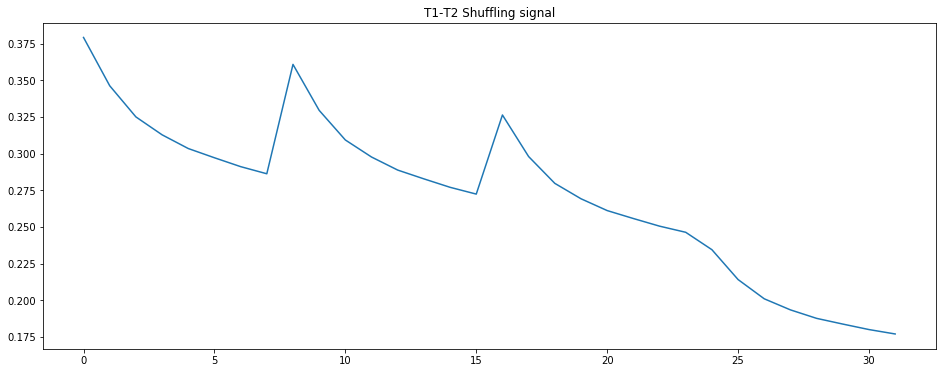

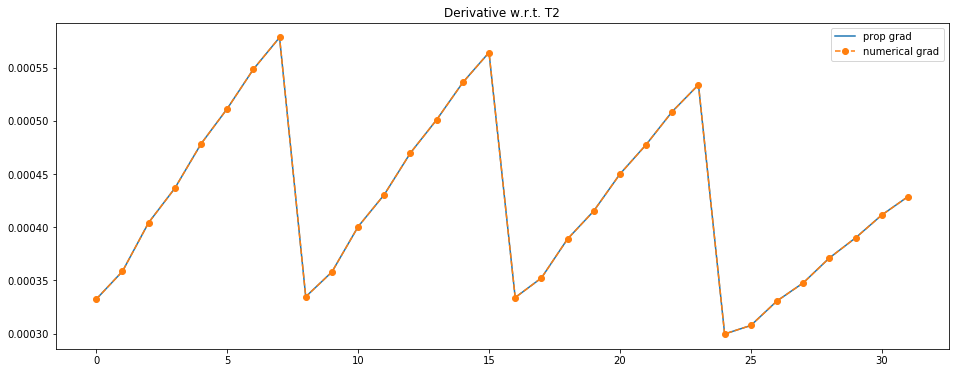

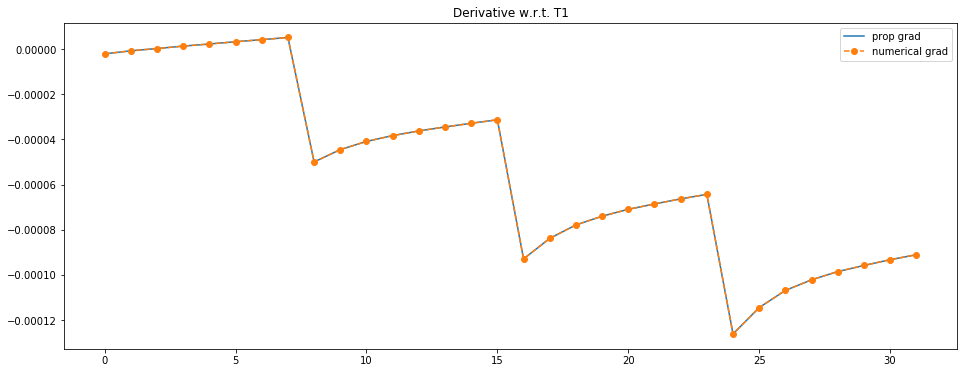

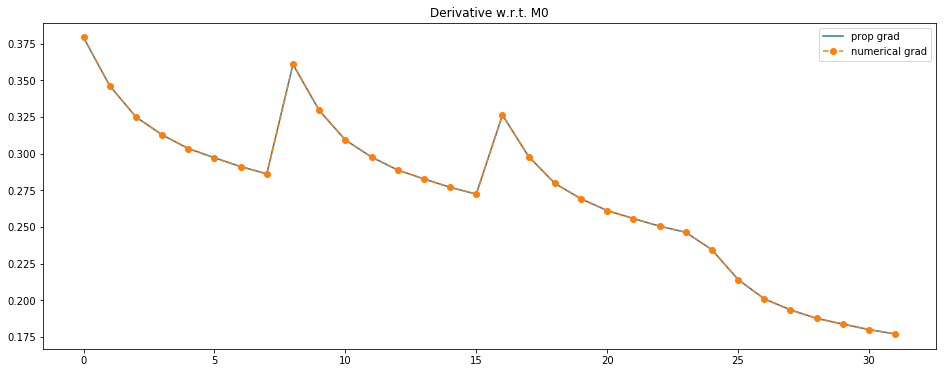

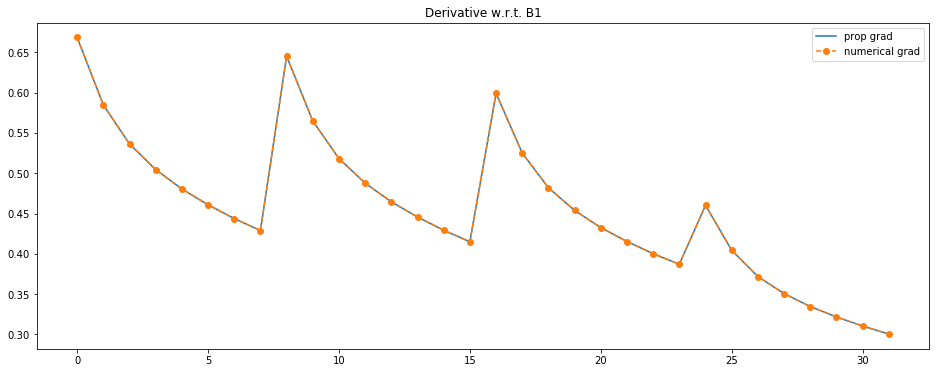

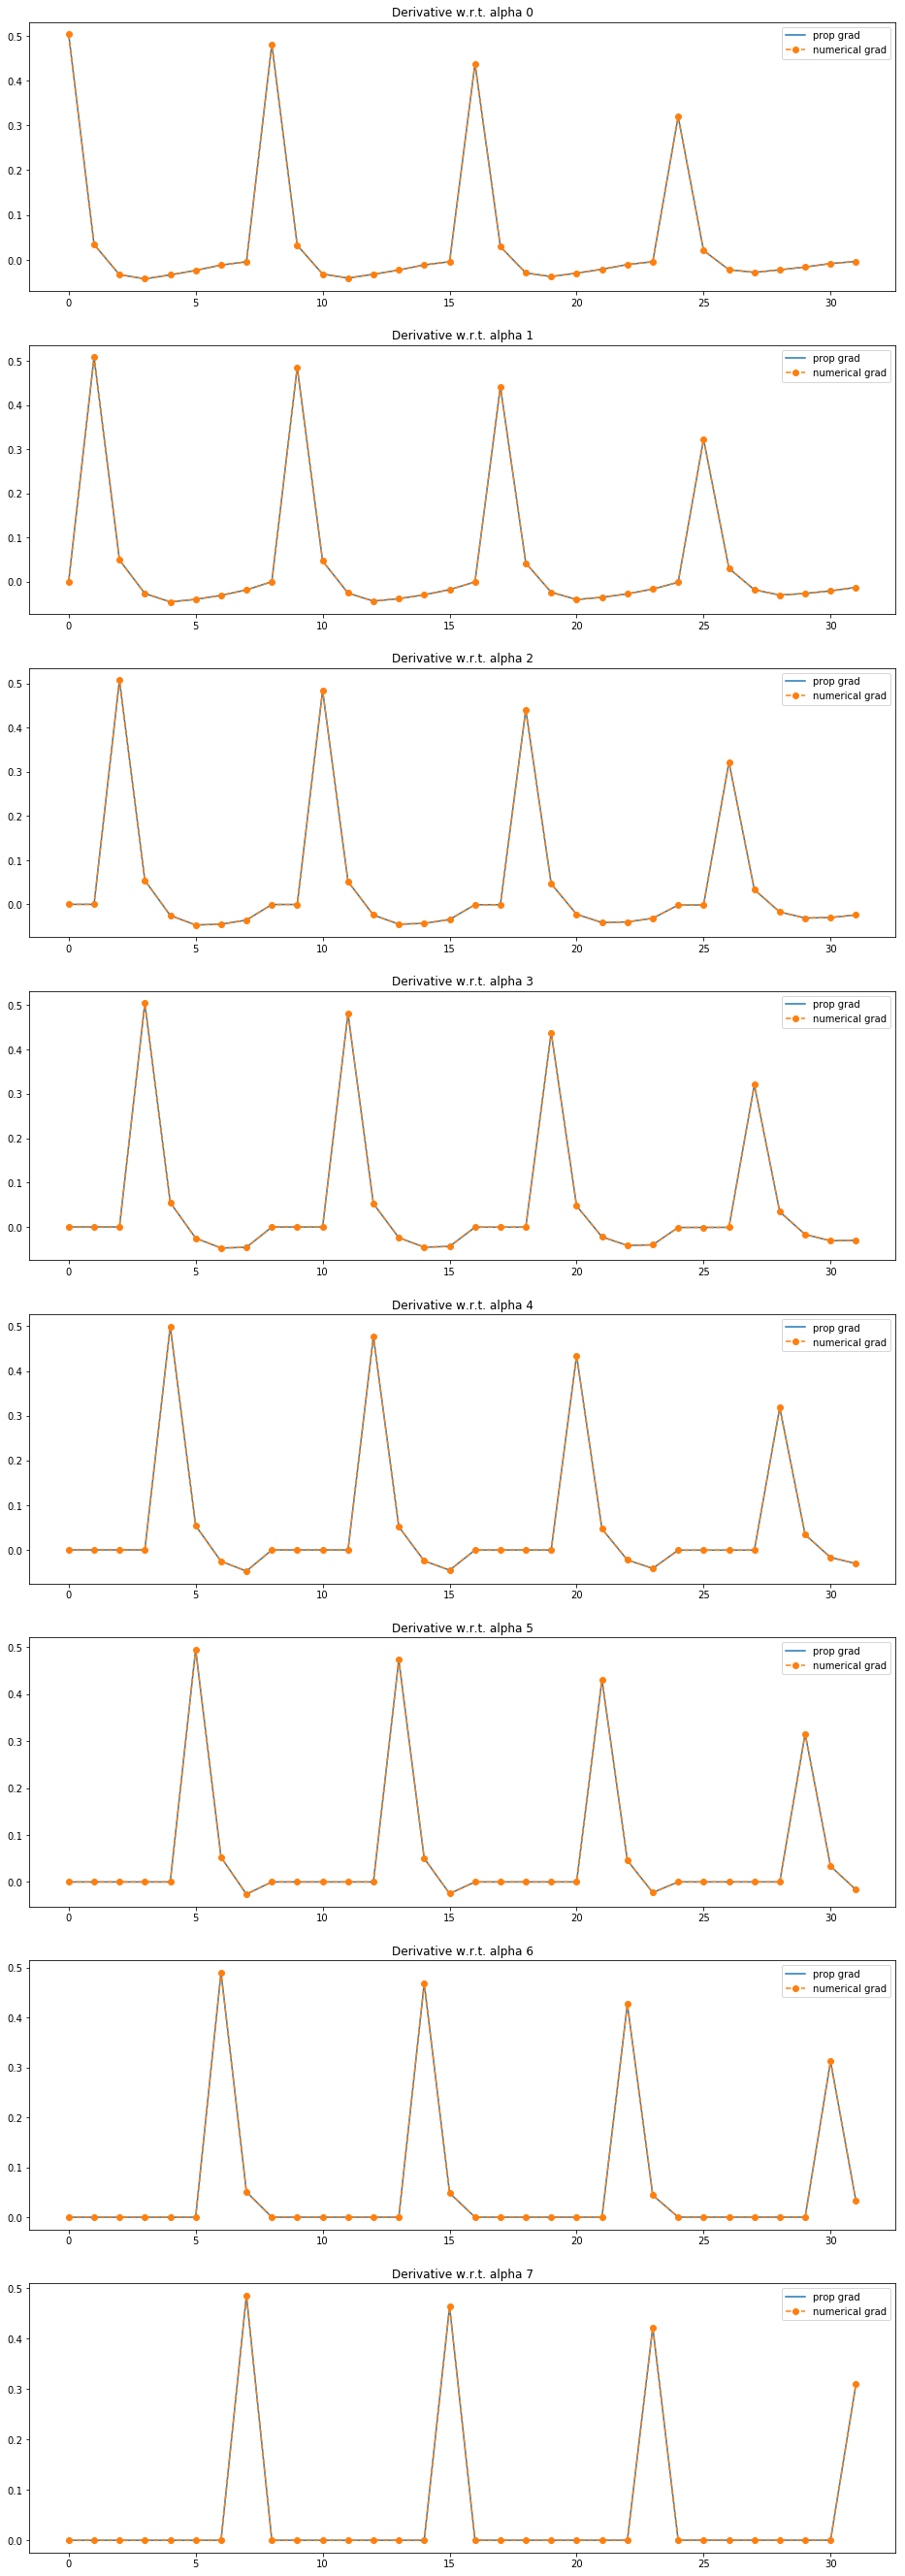

In [6]:
plt.figure(figsize=(16,6))
plt.plot(range(ETL*N), sig)
plt.title('T1-T2 Shuffling signal')

plt.figure(figsize=(16,6))
plt.plot(range(ETL*N), sig_prime_T2, range(ETL*N), w2_num.ravel(order='F'), '--o')
plt.title('Derivative w.r.t. T2')
plt.legend(('prop grad', 'numerical grad'))

plt.figure(figsize=(16,6))
plt.plot(range(ETL*N), sig_prime_T1, range(ETL*N), w1_num.ravel(order='F'), '--o')
plt.title('Derivative w.r.t. T1')
plt.legend(('prop grad', 'numerical grad'))

plt.figure(figsize=(16,6))
plt.plot(range(ETL*N), sig_prime_M0, range(ETL*N), w0_num.ravel(order='F'), '--o')
plt.title('Derivative w.r.t. M0')
plt.legend(('prop grad', 'numerical grad'))

plt.figure(figsize=(16,6))
plt.plot(range(ETL*N), sig_prime_B1, range(ETL*N), wb1_num.ravel(order='F'), '--o')
plt.title('Derivative w.r.t. B1')
plt.legend(('prop grad', 'numerical grad'))

plt.figure(figsize=(16,ETL*6))
for k in range(ETL):
    plt.subplot(ETL,1,k+1)
    plt.plot(range(ETL*N), sig_prime_alpha[k,:], range(ETL*N), wa_num[k,:,:].ravel(), '--o')

    plt.title('Derivative w.r.t. alpha %d' % k)
    plt.legend(('prop grad', 'numerical grad'))

[ 1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711  1.05175711
  1.05175711  1.05175711  1.05175711]


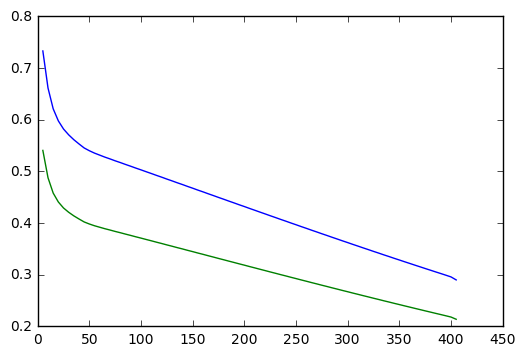

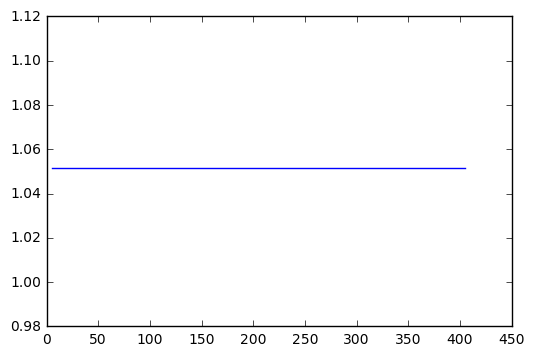

In [28]:
M0 = 1;
T1 = 500
T2 = 300
TE = 5
B1 = 1

TRs = np.array([2800, 1700, 950])

N = len(TRs)

T = 81

echo_times = np.arange(TE, TE*(T+1), TE)

angle_ex_rad = np.pi / 2

angles_rad = 120 * np.ones((T,)) * np.pi/180
angles_rad = np.pi/180 * read_angles('flipangles.txt.814192544')[:T]

sig = t1t2sh.t1t2shuffle_ex(angle_ex_rad, angles_rad, TE, TRs, M0, T1, T2, B1).reshape((-1,T))

rsig = sig[0,:]/sig[1,:]

print rsig


plt.plot(echo_times, sig[0,:], echo_times, sig[2,:])
plt.figure()
plt.plot(echo_times, rsig)